In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import torch
from matplotlib import patches
from tqdm import tqdm

Matplotlib created a temporary cache directory at /tmp/matplotlib-onldbinf because the default path (/afs/csail.mit.edu/u/a/arunas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Training accuracies

In [2]:
mistral = pd.read_csv('/mnt/align4_drive/arunas/broca/mistral/experiments/new-prompt-prologue-random-seed/acc.csv')
llama = pd.read_csv('/mnt/align4_drive/arunas/broca/llama/experiments/new-prompt-prologue-random-seed/acc.csv')

In [3]:
new_names = {'en': 'EN declarative (P)',
'en-r-1-subordinate': 'EN subordinate (P)',
'en-r-2-passive': 'EN passive (P)',
'en-u-1-negation': 'EN negative token (I)',
'en-u-2-inversion':'EN inverted (I)',
'en-u-3-qsubordinate':'EN qsubordinate (I)',
'en-u-4-wh':'EN-wh-word (I)',
'it':'$IT_S$ declarative (P)',
'it-r-1-null_subject':'$IT_S$ null subject (P)',
'it-r-2-passive':'$IT_S$ passive (P)',
'it-r-3-subordinate':'$IT_S$ subordinate (P)',
'it-u-1-negation':'$IT_S$ negative token (I)',
'it-u-2-invert':'$IT_S$ inverted (I)',
'it-u-3-gender':'$IT_S$ gender determiner (I)',
'ita':'$IT_T$ declarative (P)',
'ita-r-1-null_subject':'$IT_T$ null subject (P)',
'ita-r-3-passive':'$IT_T$ passive (P)',
'ita-r-2-subordinate':'$IT_T$ subordinate (P)',
'ita-u-1-negation':'$IT_T$ negative (I)',
'ita-u-2-invert':'$IT_T$ inverted (I)',
'ita-u-3-gender':'$IT_T$ gender determiner (I)',
'jap-r-1-sov':'$JP_T$ declarative (P)',
'jap-r-2-passive':'$JP_T$ passive (P)',
'jap-u-1-negation':'$JP_T$ negative token(I)',
'jap-u-2-invert':'$JP_T$ inverted (I)',
'jp-r-1-sov':'$JP_S$ declarative (P)',
'jp-r-2-passive':'$JP_S$ passive (P)',
'jp-r-3-subordinate':'$JP_S$ subordinate (P)',
'jp-u-1-negation':'$JP_S$ negative token (I)',
'jp-u-2-invert':'$JP_S$ inverted (I)',
'jp-u-3-past-tense':'$JP_S$ incorrect past tense (I)'}

real 0 0 3 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
unreal 0 0 4 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
real 1 3 7 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
unreal 1 4 7 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
real 2 7 11 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
unreal 2 7 10 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
real 3 11 13 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
unreal 3 10 12 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
real 4 13 16 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 3}, {'r': 2, 'u': 2}, {'r': 3, 'u': 3}]
unreal 4 12 15 [{'r': 3, 'u': 4}, {'r': 4, 'u': 3}, {'r': 4, 'u': 

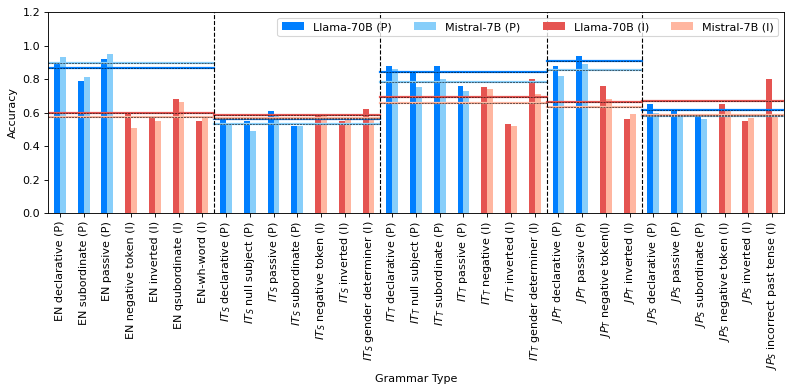

In [8]:
merged = pd.merge(mistral, llama, on='type', how='outer')
merged = merged.rename(columns={'accuracy_x': 'mistral', 'accuracy_y': 'llama'})
merged.index=merged['type']
merged.drop( ['type'], inplace=True, axis=1)
merged = merged.T
merged.loc[merged.index=='llama'].values
m_colors = { 'r': '#87CEFA', 'u': '#FFB6A0' }
l_colors = { 'r': '#007FFF', 'u': '#E55451' }
bp_colors = []
real_indices = []
mistral_real = []
llama_real = []
unreal_indices = []
mistral_unreal = []
llama_unreal = []

for idx, i in enumerate(merged.columns):
    if ('-r-' in i) or (not ('-' in i)):
        bp_colors.append(m_colors['r'])
        bp_colors.append(l_colors['r'])
        real_indices.append(idx)
        mistral_real.append(merged.loc[merged.index=='mistral'][i].item())
        llama_real.append(merged.loc[merged.index=='llama'][i].item())
    else:
        bp_colors.append(m_colors['u'])
        bp_colors.append(l_colors['u'])
        unreal_indices.append(idx)
        mistral_unreal.append(merged.loc[merged.index=='mistral'][i].item())
        llama_unreal.append(merged.loc[merged.index=='llama'][i].item())

counts =  [ {'r': 3, 'u':4}, {'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
            #en               #it              #ita             #jap            #jp
llama_avg_accuracies = { 'real': [], 'unreal': [] }
mistral_avg_accuracies = { 'real': [], 'unreal': [] }

fig = plt.figure(figsize=(10, 5), dpi=80) 
plt.bar(np.array(real_indices)-0.125, llama_real, color=['#007FFF'], width=0.25, label='Llama-70B (P)')
plt.bar(np.array(real_indices)+0.125, mistral_real, color=['#87CEFA'], width=0.25, label='Mistral-7B (P)')
plt.bar(np.array(unreal_indices)-0.125, llama_unreal, color=['#E55451'], width=0.25, label='Llama-70B (I)')
plt.bar(np.array(unreal_indices)+0.125, mistral_unreal, color=['#FFB6A0'], width=0.25, label='Mistral-7B (I)')
plt.xticks(np.arange(len(merged.columns)), labels=[new_names[col] for col in merged.columns], rotation=90)
plt.ylim(0, 1.2)
for idx, count in enumerate(counts):
    if (idx == 0):
        start = 0
    else:
        start = sum([val['r'] for i, val in enumerate(counts) if i < idx])
    stop = start + counts[idx]['r']
    print('real', idx, start, stop, counts)
    llama_avg_accuracies['real'].append(sum(llama_real[start:stop])/count['r'])
    mistral_avg_accuracies['real'].append(sum(mistral_real[start:stop])/count['r'])

    start = 0
    if (idx == 0):
        start = 0
    else:
        start += sum([val['u'] for i, val in enumerate(counts) if i < idx])
    stop = start + counts[idx]['u']
    print('unreal', idx, start, stop, counts)
    llama_avg_accuracies['unreal'].append(sum(llama_unreal[start:stop])/count['u'])
    mistral_avg_accuracies['unreal'].append(sum(mistral_unreal[start:stop])/count['u'])

# print(llama_avg_accuracies, mistral_avg_accuracies)
for idx in range(len(llama_avg_accuracies['real'])):
    if (idx == 0):
        start = 0
        stop = counts[idx]['r'] + counts[idx]['u']
    else:
        start = sum([counts[m]['r'] + counts[m]['u'] for m in range(len(llama_avg_accuracies['real'])) if m < idx])
        stop = start + counts[idx]['r'] + counts[idx]['u']        

    plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['real'][idx], llama_avg_accuracies['real'][idx]], linestyle='-', linewidth=2, color='#007FFF')
    plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['real'][idx], llama_avg_accuracies['real'][idx]], linestyle='--', linewidth=0.5, color='black')
    
    plt.plot([start - 0.5 , stop - 0.5], [mistral_avg_accuracies['real'][idx], mistral_avg_accuracies['real'][idx]], linestyle='-', linewidth=2, color='#87CEFA')
    plt.plot([start - 0.5, stop - 0.5], [mistral_avg_accuracies['real'][idx], mistral_avg_accuracies['real'][idx]], linestyle='--', linewidth=0.5, color='black')
    
    plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['unreal'][idx], llama_avg_accuracies['unreal'][idx]], linestyle='-', linewidth=2, color='#E55451')
    plt.plot([start - 0.5, stop - 0.5], [llama_avg_accuracies['unreal'][idx], llama_avg_accuracies['unreal'][idx]], linestyle='--', linewidth=0.5, color='black')
    
    plt.plot([start - 0.5, stop - 0.5], [mistral_avg_accuracies['unreal'][idx], mistral_avg_accuracies['unreal'][idx]], linestyle='-', linewidth=2, color='#FFB6A0')
    plt.plot([start - 0.5, stop - 0.5], [mistral_avg_accuracies['unreal'][idx], mistral_avg_accuracies['unreal'][idx]], linestyle='--', linewidth=0.5, color='black')

print(llama_avg_accuracies, mistral_avg_accuracies)

plt.legend(ncol=4)
plt.xlim(left=-0.5, right=30.5)
plt.xlabel('Grammar Type')
plt.ylabel('Accuracy')
plt.axvline(x=6.5, linestyle='--', linewidth=1, color='black')
plt.axvline(x=13.5, linestyle='--', linewidth=1, color='black')
plt.axvline(x=20.5, linestyle='--', linewidth=1, color='black')
plt.axvline(x=24.5, linestyle='--', linewidth=1, color='black')
fig.tight_layout()
plt.savefig('/mnt/align4_drive/arunas/broca/mistral/experiments/new-prompt-prologue-random-seed/model-accuracies.png')
plt.savefig('/mnt/align4_drive/arunas/broca/llama/experiments/new-prompt-prologue-random-seed/model-accuracies.png')

In [ ]:
counts =  [ {'r': 3, 'u':4}, {'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
            #en               #it              #ita             #jap            #jp
llama_avg_accuracies = { 'real': [], 'unreal': [] }
mistral_avg_accuracies = { 'real': [], 'unreal': [] }

for idx, item in enumerate(counts):
    start_idx = [val['r'] + val['u'] for i in enumerate(counts) if i < idx] or 0
    stop_idx = start_idx + counts['r']
    llama_avg_accuracies['real'].append(sum(llama_reals[start_idx:stop_idx])/counts['r'])
    mistral_avg_accuracies['real'].append(sum(mistral_reals[start_idx:stop_idx])/counts['r'])

    start_idx = [val['r'] + val['u'] for i in enumerate(counts) if i < idx] or 0
    start_idx += counts['r']
    stop_idx = start_idx + counts['u']

    llama_avg_accuracies['unreal'].append(sum(llama_unreals[start_idx:stop_idx])/counts['u'])
    mistral_avg_accuracies['unreal'].append(sum(mistral_unreals[start_idx:stop_idx])/counts['r'])



## Top 1% neurons confusion matrix

In [5]:
PREFIX = '/mnt/align4_drive'
component = 0
def conf_matrix(model, compPath, topK, subpath):
    global component
    print('Generating conf matrix')
    og = pd.read_csv(f'{PREFIX}/arunas/broca/data-gen/ngs.csv')
    columns = [col for col in sorted(og.columns) if not 'ng-' in col]
    columns = [col for col in sorted(columns) if (('en' in col[:2]) or ('ita' in col[:3]) or ('jap' in col[:3])) and (not ('qsub' in col)) ]
    # columns = [col for col in sorted(columns) if not ('en' in col[:2]) ]
    print(columns)
    component = pd.DataFrame(columns=np.arange(0,65530), index=sorted(columns))
    for col in sorted(columns):
        with open(f'{PREFIX}/arunas/broca/{model}/atp/patches/{compPath}/{subpath}/{col}.pkl', 'rb') as f:
            component_cache = pickle.load(f)
            component_cache = component_cache.cpu()
            flattened_effects_cache = component_cache.view(-1)
            top_neurons = flattened_effects_cache.topk(k=int(topK * flattened_effects_cache.shape[-1]))
            two_d_indices = torch.cat((((top_neurons[1] // component_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % component_cache.shape[1]).unsqueeze(1))), dim=1)            
            df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])
            for idx, row in df.iterrows():
                component.loc[(component.index==col),idx] = ",".join([str(row['layer']), str(row['neuron'])])
    print(idx)
    print('Gathered pickles')
    component = component[list(component.columns)[:idx]]
    component_overlap = pd.DataFrame(columns=sorted(component.index), index=sorted(component.index))
    for col in tqdm(sorted(component.index)):
        for col1 in sorted(component.index):
            component_overlap.loc[(component_overlap.index == col), col1] = len(set(component.loc[col]).intersection(set(component.loc[col1])))/len(component.columns)
        component_overlap[col] = component_overlap[col].astype(float)
    print('Generating chart')
    # lower_triangle_mask = np.tril(np.ones(component_overlap.shape)).astype(bool)
    # component_overlap = component_overlap.where(lower_triangle_mask)
    plt.imshow(component_overlap, cmap='binary', aspect='auto', interpolation='nearest')
    ax = plt.gca()
    plt.xticks(range(len(sorted(component_overlap.columns))), labels=[new_names[col] for col in component_overlap.columns])
    plt.yticks(range(len(sorted(component_overlap.index))), labels=[new_names[col] for col in component_overlap.columns])
    plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
    plt.yticks(fontsize=8)  # Set y-axis tick label font size
    plt.colorbar()
    plt.title(f'{model.title()} {compPath.title()}')
    plt.tight_layout()

    # -------------------------------- Draw lines -------------------------------------------------
    if model == 'llama':
        real_color = '#007FFF'
        unreal_color = '#E55451'
    elif model == 'mistral':
        real_color = '#87CEFA'
        unreal_color = '#FFB6A0'
    sortCols = sorted(component_overlap.columns)
    real_xticks = [(idx+0.5, col) for idx, col in enumerate(sortCols[:-1]) if '-u-' in sortCols[idx+1] and '-r-' in col]
    unreal_xticks = [ (idx+0.5, col) for idx, col in enumerate(sortCols) if ('it-u-3-' in col ) or ('ita-u-3-' in col ) or ('jp-u-3-' in col) or ('jap-u-2-' in col) or ('en-u-4' in col) ]
    
    # for rx_tick, ux_tick in zip(real_xticks, unreal_xticks):
    #     plt.axvline(x=rx_tick[0], color=real_color)
    #     plt.axvline(x=ux_tick[0], color=unreal_color)
    #     plt.axhline(y=rx_tick[0], color=real_color)
    #     plt.axhline(y=ux_tick[0], color=unreal_color)
        
    # counts =  [ {'r': 3, 'u':3}, {'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
    #             #en               #it              #ita             #jap            #jp
    counts =  [ {'r': 3, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}]
                #en               #ita             #jap
    # counts =  [ {'r': 3, 'u':3}, {'r': 4, 'u':3}, {'r': 3, 'u':3}]
    # #             #en               #it           #jp
    # counts =  [{'r': 4, 'u':3}, {'r': 4, 'u':3}, {'r': 2, 'u':2}, {'r': 3, 'u':3}]
    #            #it              #ita             #jap            #jp
    for lid in range(len(counts)):
        for lid1 in range(len(counts)):
    
            x = sum([ l['r'] for li, l in enumerate(counts) if li < lid]) + sum([ l['u'] for li, l in enumerate(counts) if li < lid])
            y = sum([ l['r'] for li, l in enumerate(counts) if li < lid1]) + sum([ l['u'] for li, l in enumerate(counts) if li < lid1])
            
            width = counts[lid]['r']
            height = counts[lid1]['r']
            rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=2, facecolor='none', edgecolor=real_color)
            ax.add_patch(rect)
            rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=0.5, facecolor='none', edgecolor='black', linestyle='--')
            ax.add_patch(rect)
            
            x = sum([ l['u'] for li, l in enumerate(counts) if li < lid]) + sum([ l['r'] for li, l in enumerate(counts) if li < lid]) + counts[lid]['r']
            y = sum([ l['u'] for li, l in enumerate(counts) if li < lid1]) + sum([ l['r'] for li, l in enumerate(counts) if li < lid1]) + counts[lid1]['r']
            
            width = counts[lid]['u']
            height = counts[lid1]['u']
            rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=2, facecolor='none', edgecolor=unreal_color)
            ax.add_patch(rect)
            rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=0.5, facecolor='none', edgecolor='black', linestyle='--')
            ax.add_patch(rect)
            # print(x, y, width, height)
            # rect = patches.Rectangle((x - 0.5,y - 0.5), width, height, linewidth=5, facecolor=(0.24, 0.70, 0.44, 0.2))
            ax.add_patch(rect)
        
    plt.savefig(f'/mnt/align4_drive/arunas/broca/ts-{model}-{compPath}-overlap-{topK}.png')
    plt.show()

Generating conf matrix
['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh', 'ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender', 'jap-r-1-sov', 'jap-r-2-passive', 'jap-u-1-negation', 'jap-u-2-invert']
6552
Gathered pickles


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 46.29it/s]


Generating chart


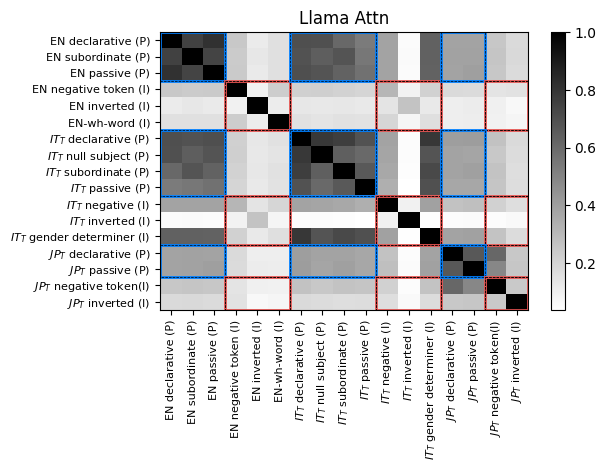

Generating conf matrix
['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh', 'ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender', 'jap-r-1-sov', 'jap-r-2-passive', 'jap-u-1-negation', 'jap-u-2-invert']
6552
Gathered pickles


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 46.69it/s]


Generating chart


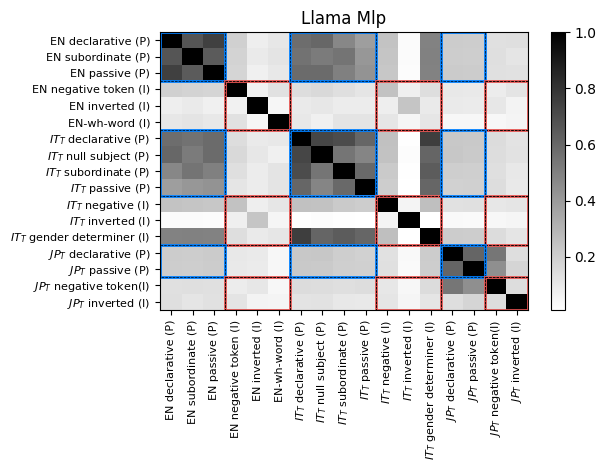

Generating conf matrix
['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh', 'ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender', 'jap-r-1-sov', 'jap-r-2-passive', 'jap-u-1-negation', 'jap-u-2-invert']
1309
Gathered pickles


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 148.82it/s]

Generating chart


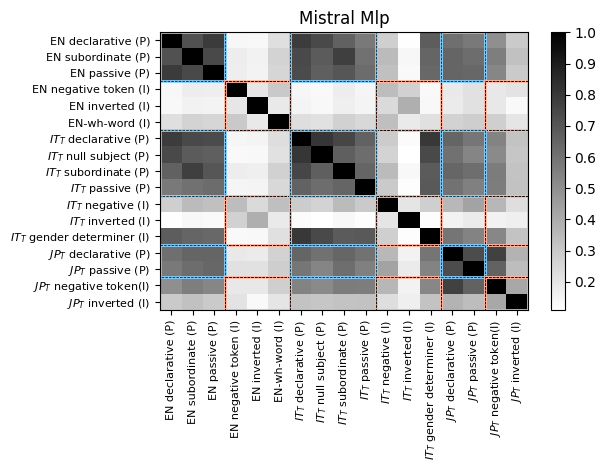

Generating conf matrix
['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-4-wh', 'ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender', 'jap-r-1-sov', 'jap-r-2-passive', 'jap-u-1-negation', 'jap-u-2-invert']
1309
Gathered pickles


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 148.96it/s]

Generating chart


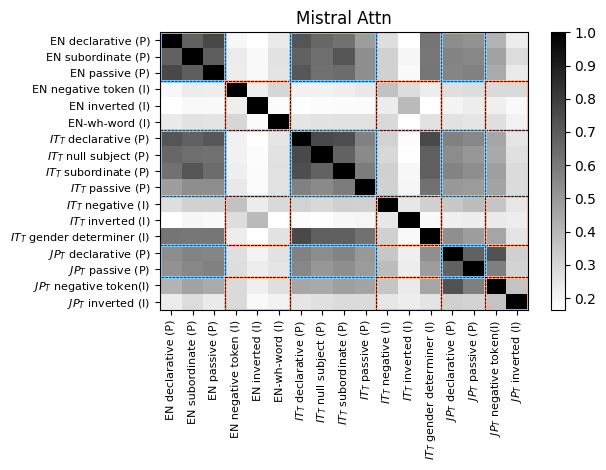

In [6]:
conf_matrix('llama', 'attn', 0.01, 'all-neurons-new-prompt-prologue-random-seed')
conf_matrix('llama', 'mlp', 0.01, 'all-neurons-new-prompt-prologue-random-seed')
conf_matrix('mistral', 'mlp', 0.01, 'all-neurons-new-prompt-prologue-random-seed')
conf_matrix('mistral', 'attn', 0.01, 'all-neurons-new-prompt-prologue-random-seed')

In [ ]:
# model = 'llama'
# compPath = 'attn'
# subpath = 'all-neurons-new-prompt-prologue-random-seed'
# col = 'en'
# topK = 0.01
# with open(f'{PREFIX}/arunas/broca/{model}/atp/patches/{compPath}/{subpath}/{col}.pkl', 'rb') as f:
#     component_cache = pickle.load(f)
#     component_cache = component_cache.cpu()
#     flattened_effects_cache = component_cache.view(-1)
#     top_neurons = flattened_effects_cache.topk(k=int(topK * flattened_effects_cache.shape[-1]))
#     two_d_indices = torch.cat((((top_neurons[1] // component_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % component_cache.shape[1]).unsqueeze(1))), dim=1)            
#     df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])

In [96]:
flattened_effects_cache

tensor([0., 0., 0.,  ..., 0., 0., 0.])

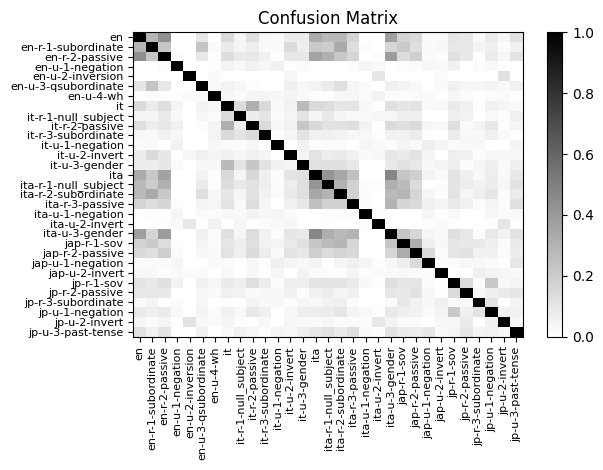

In [102]:
# columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
# filtered_columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']
og = pd.read_csv('/mnt/align4_drive/arunas/broca/data-gen/ngs.csv')
columns = [col for col in og.columns if not 'ng-' in col]
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in sorted(columns):
    with open(f'/mnt/align4_drive/arunas/broca/llama/atp/patches/mlp/all-neurons/{col}.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        flattened_effects_cache = x.view(-1)
        top_neurons = flattened_effects_cache.topk(k=int(0.01 * flattened_effects_cache.shape[-1]))
        two_d_indices = torch.cat((((top_neurons[1] // x.shape[1]).unsqueeze(1)), ((top_neurons[1] % x.shape[1]).unsqueeze(1))), dim=1)    
        df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
# mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[sorted(columns)]

mlp_overlap = pd.DataFrame(columns=sorted(mlp.columns), index=sorted(mlp.columns))

for col in sorted(mlp.columns):
    for col1 in sorted(mlp.columns):
         if (len(mlp[mlp[col] == 1]) > 0):
             mlp_overlap.loc[(mlp_overlap.index == col), col1] = len( mlp[(mlp[col] == mlp[col1]) & (mlp[col] == 1)] )/len(mlp[(mlp[col] == 1) | (mlp[col1] == 1)] - mlp[(mlp[col] == 1) & (mlp[col1] == 1)])
    mlp_overlap[col] = mlp_overlap[col].astype(float)


plt.imshow(mlp_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp_overlap.columns)), sorted(mlp_overlap.columns))
plt.yticks(range(len(mlp_overlap.index)), sorted(mlp_overlap.index))
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
plt.colorbar()
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Distribution of activations of all neurons

In [71]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
layer31 = []
layer0 = []
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, index=range(32), columns=range(4096))
        layer31.append(df[df.index==31].values[0,:])
        layer0.append(df[df.index==0].values[0,:])

/state/partition1/slurm_tmp/25169865.0.0/ipykernel_1432574/3215867080.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation=90)


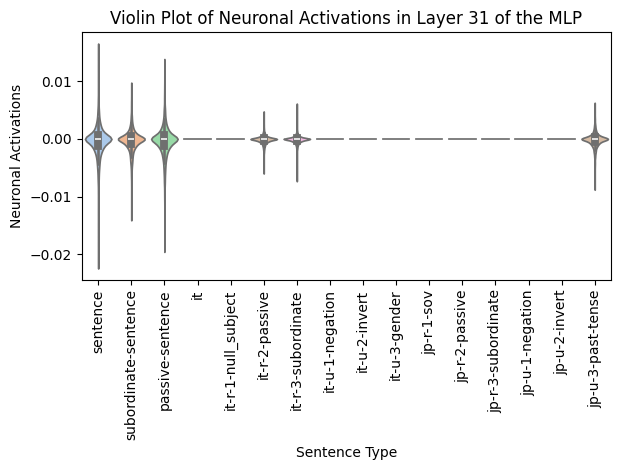

In [72]:


ax = sns.violinplot(data=layer31,  palette="pastel")
ax.set_xticklabels(columns, rotation=90)
plt.xlabel('Sentence Type')
plt.ylabel('Neuronal Activations')
plt.title('Violin Plot of Neuronal Activations in Layer 31 of the MLP')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-neuron-dists.png')
plt.show()

In [73]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
attn = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
attn['neuron'] = np.arange(0,4096)
attn[columns] = 0
attn['layer'] = 31
layer31 = []
layer0 = []
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, index=range(32), columns=range(4096))
        layer31.append(df[df.index==31].values[0,:])
        layer0.append(df[df.index==0].values[0,:])

/state/partition1/slurm_tmp/25169865.0.0/ipykernel_1432574/2836353760.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation=90)


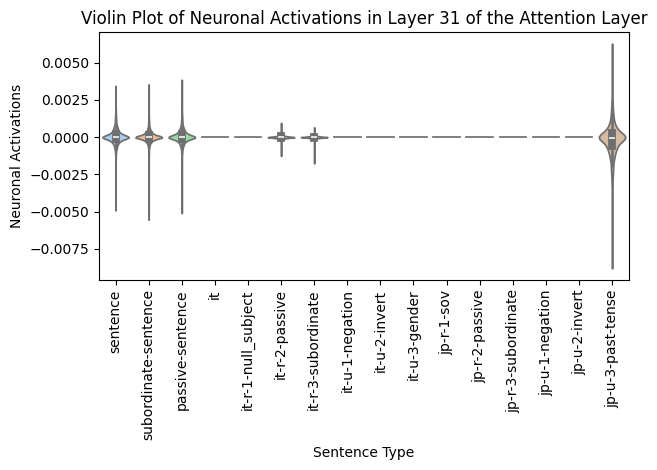

In [74]:


ax = sns.violinplot(data=layer31,  palette="pastel")
ax.set_xticklabels(columns, rotation=90)
plt.xlabel('Sentence Type')
plt.ylabel('Neuronal Activations')
plt.title('Violin Plot of Neuronal Activations in Layer 31 of the Attention Layer')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/attn-neuron-dists.png')
plt.show()

## All neurons confusion matrix

In [75]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
filtered_columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
# mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[columns]

mlp_overlap = pd.DataFrame(columns=mlp.columns, index=mlp.columns)

for col in mlp.columns:
    for col1 in mlp.columns:
        mlp_overlap.loc[(mlp_overlap.index == col), col1] = float(( (mlp[col] == mlp[col1]) & (mlp[col] != 0) ).sum()/len(mlp))
    mlp_overlap[col] = mlp_overlap[col].astype(float)

plt.imshow(mlp_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp_overlap.columns)), mlp_overlap.columns)
plt.yticks(range(len(mlp_overlap.index)), mlp_overlap.index)
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
# plt.grid(True)
plt.colorbar()
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-overlap-all.png')
plt.show()

ValueError: Shape of passed values is (32, 4096), indices imply (32, 2)

In [130]:
model = 'mistral'
compPath = 'attn'
topK = 0.01
subpath = 'all-neurons-new-prompt-prologue-random-seed'
col = 'en'

with open(f'{PREFIX}/arunas/broca/{model}/atp/patches/{compPath}/{subpath}/{col}.pkl', 'rb') as f:
    component_cache = pickle.load(f)
    component_cache = component_cache.cpu()
    flattened_effects_cache = component_cache.view(-1)
    top_neurons = flattened_effects_cache.topk(k=int(topK * flattened_effects_cache.shape[-1]))
    two_d_indices = torch.cat((((top_neurons[1] // component_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % component_cache.shape[1]).unsqueeze(1))), dim=1)            
    df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])

In [134]:
with open(f'{PREFIX}/arunas/broca/{model}/atp/patches/{compPath}/mean-patches/{col}.pkl', 'rb') as f:
    component_cache = pickle.load(f)
    component_cache = component_cache.cpu()
    print(component_cache

torch.Size([32, 332, 4096])
